Librerías

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import psutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import random
import math
from scipy.spatial.distance import cityblock
from sklearn.decomposition import PCA
from scipy.spatial import distance as dist
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from sklearn.feature_extraction import text
from sklearn.metrics import confusion_matrix, f1_score
inline_rc = dict(mpl.rcParams)

Algoritmo de clustering jerárquico

In [ ]:
def hierarchicalClustering(distance_matrix, linkType, numClusters):
    '''Método para aplicar sobre una matriz de distancias el clustering jerárquico
    Parámetros:
    -distance_matrix: la matriz de distancias de las instancias
    -linkType: indica el tipo de enlace que se va a utilizar. Sus valores pueden ser:
        -'single': Single link
        -'complete': Complete link
        -'average': Average link
    -numClusters: el número de clusters que se quiere conseguir'''

    print(distance_matrix)


    for samples in range(1, len(distance_matrix)): #Para cada instancia en distance_matrix
        print('Uso de la memoria en MB:')
        memory_usage_psutil()
        print('-----------------------------')


        if len(distance_matrix) == numClusters:#Si el número de clusters actual se corresponde con el número de clusters deseado
            print(distance_matrix)
            print('Altura de corte:', minn)#Se notifica la altura máxima alcanzada
            return distance_matrix #Se devuelve como resultado la matriz de distancias

        print('iteración número:', samples)
        #PASO 1: Obtención de la distancia mínima e identificación de nodos que se van a aglomerar
        #La variable minn representa el valor de la distancia mínima de la matriz de distancias
        #La variable x representa la coordenada x de minn
        #la variable y representa la coordenada y de minn
        x,y,minn = calculateMin(distance_matrix)#Obtenemos las coordenadas del valor más pequeño de la matriz junto a sus coordenadas

        #Guardamos las dos instancias que más cerca se encuentran en variables separadas
        #Las variables node1 y node2 representan las instancias a unir
        print('Clusters aglomerados:')
        element1 = distance_matrix.iloc[y].array
        print('Cluster 1:', distance_matrix.iloc[y].name)
        element2 = distance_matrix.iloc[x].array
        print('Cluster 2:', distance_matrix.iloc[x].name)

        #PASO 2: Unificación de node1 y node2 y obtención del vector de distancias del nuevo nodo aglomerado
        newValues = newDistances(element1, element2, linkType, minn, len(distance_matrix))

        if newValues is None: #Si la obtención del vecotr de distancias del cluster nuevo no ha sido un éxito
            print('Tipo de enlace incorrecto')
            return None

        #PASO 3:Modificación de la matriz de distancia
        distance_matrix = mergeClusters(distance_matrix,newValues,x,y)#Se intercambian node1 y node2 por el nodo producto de su unión
        if(len(distance_matrix)) < 6: # Solo se imprimira si la matriz tiene menos de 6 dimensiones
            print(distance_matrix)
            print('-----------------------------')
    #En caso de indicar un número de clsuters superior a el número de clusters posibles
    return distance_matrix #El resultado es la matriz de distancias con todas las instancias aglomeradas en un cluster

Rutinas de hierarchicalClustering()

In [ ]:
def calculateMin(distance_matrix):
    '''Método para encontrar el valor mínimo de la matriz de distancias y sus coordenadas
    Parámetros:
    -distance_matriz: estructura de datos que contiene todas las distancias ya sea entre interclusters o interinstancias'''
    minimumValues=np.matrix(distance_matrix).argmin(axis = 1).tolist() #Obtenemos una lista con los valores mínimos de cada columna de la matriz de distancias
    #Guardamos en la variable minn el valor mínimo de la primera columna, en las variables x e y, sus coordenadas
    minn=distance_matrix.iloc[minimumValues[0][0],0]
    y=0
    x=minimumValues[0][0]

    for i in range(1,len(minimumValues)-1):#Para cada mínimo en la lista de mínimos
        if distance_matrix.iloc[minimumValues[i][0],i] < minn: #Si el mínimo en la posición i de la lista de mínimos es más pequeño que el mínimo actual
            #Guardamos en la variable minn el valor mínimo nuevo y las variables x e y, sus coordenadas
            minn=distance_matrix.iloc[minimumValues[i][0],i]
            x=minimumValues[i][0]
            y=i

    return x,y,minn #El resultado que devuelve el método son las coordenadas x e y del mínimo y el mínimo en si.
    #Nota: Este método a primera vista parece ser innecesario y que podría sustituirse por una línea de código,
    # sin embargo, pandas.DataFrame no posee ningún método para devolver el valor mínimo de todo el Dataframe.


def newDistances(element1, element2, linkType, minn, lenMatrix):
    '''Método para conseguir el vector de distancias del cluster aglomerado

    Parámetros:
    -element1: vector de distancias de un cluster o una instancia
    -element2: vector de distancias de un cluster o una instancia
    -linkType: indica el tipo de enlace que se va a utilizar. Sus valores pueden ser:
        -'single': Single link
        -'complete': Complete link
        -'average': Average link
    -minn: la distancia mínima de la matriz de distancias
    -lenMatrix: número de instancias y/o clusters que hay en la matriz de distancias'''
    #newValues es la variable que contiene las distancias del nuevo nodo
    if linkType == 'single': #Si linktype es 'single' se va a emplear la técnica de single link
        newValues = singleLink(element1,element2,minn,lenMatrix) #Se guarda en newValues el vector de distancias del nuevo nodo

    elif linkType == 'complete': #Si linktype es 'complete' se va a emplear la técnica de complete link
        newValues = completeLink(element1,element2,minn,lenMatrix)#Se guarda en newValues el vector de distancias del nuevo nodo

    elif linkType == 'average': #Si linktype es 'average' se va a emplear la técnica de average link
        newValues = averageLink(element1,element2,minn,lenMatrix)#Se guarda en newValues el vector de distancias del nuevo nodo
    else:
        return None #Si linktype no es correcto el método devuelve None

    return newValues

def mergeClusters(distance_matrix,newValues,x,y):
    '''Método para modificar la matriz de distancias para que quede refljada la unificación de dos clusters o instancias en ella
    Parámetros:
    -distance_matrix: estructura de datos que contiene todas las distancias ya sea entre interclusters o interinstancias
    -newValues: estructura de datos que contiene los valores de distancias que le corresponden al cluster aglomerado
    -x: coordenada x del valor mínimo de la matriz de distancias
    -y: coordenada y del valor mínimo de la matriz de distancias'''

    label = str(distance_matrix.columns[y]) + '-' + str(distance_matrix.columns[x])#Creación de la etiqueta nueva del cluster
    distance_matrix = distance_matrix.drop([distance_matrix.iloc[x].name], axis=1) #Eliminación de la columna en la posicion x de uno de los cluster o instancias aglomeradas
    distance_matrix = distance_matrix.drop([distance_matrix.iloc[x].name], axis=0) #Eliminación de la fila en la posicion y de uno de los cluster o instancias aglomeradas
    distance_matrix = distance_matrix.rename({distance_matrix.iloc[y].name:  label}, axis='columns') #Cambio del nombre de la columna en la posicion y de uno de los cluster o instancias aglomeradas
    distance_matrix = distance_matrix.rename({distance_matrix.iloc[y].name:  label}, axis='rows') #Cambio del nombre de la fila en la posicion y de uno de los cluster o instancias aglomeradas

    #Intercambio de los valores anteriores por los nuevos
    distance_matrix.loc[label]=newValues
    distance_matrix.loc[:, label]=newValues

    return distance_matrix #El resultado es una matriz de distancias modificada que refleja la unión de instancias o clusters

Rutinas de newDistances()

In [ ]:

def averageLink(element1, element2, minn, lenMatrix):
    '''Método para crear vector de distancias a partir de los vecotres de distancias de elemento 1 y 2 mediante average link
    Parámetros:
    -element1: vector de distancias de un cluster o una instancia
    -element2: vector de distancias de un cluster o una instancia
    -minn: la distancia mínima de la matriz de distancias
    -lenMatrix: cantidad de columnas de la matriz de distancias
    Average link consiste en asignar en la posición n del vecotr de distancias del cluster aglomerado, la media entre los valores de  en la posición n de element1 y element2'''

    deleted = False
    newValues = []

    for i in range(0,lenMatrix): #Para cada posición en element1 y element2

        if not deleted: #Si todavía no se ha tratado la pareja de distancia entre el mismo elemento y el mínimo por primera vez
            if((element2[i] == minn and element1[i] == 10**4)): #Si se trata de la pareja de valores de mínimo y distancia entre el mismo elemento por primera vez
                newValues.append(float(10**4)) #Se añade en la posición i del vector nuevo el valor correspondiente a una distancia entre el mismo elemento
                deleted = True
            else: #Si se trata de pareja de valores ordinarios
                newValues.append((element1[i] + element2[i]) / 2)  #Se adjuna al vector de distancias la media de los valores en la posición i de elemento1 y elemento2
        else: #Si se ha tratado la pareja distancia entre el mismo elemento y el mínimo por primera vez
            if element2[i] == 10**4: #Si se trata de la pareja de valores de mínimo y distancia entre el mismo elemento por segunda vez
                pass #No se adjunta al vector de distancias nuevo
            else: #Si se trata de pareja de valores ordinarios
                newValues.append((element1[i] + element2[i]) / 2) #Se adjuna al vector de distancias nuevo la media de los valores en la posición i de elemto1 y elemento2

    return newValues #El resultado devuelto es el vector de distancias del cluster aglomerado

def completeLink(element1, element2, minn, lenMatrix):
    '''Método para crear vector de distancias a partir de los vecotres de distancias de elemento 1 y 2 mediante complete link
    Parámetros:
    -element1: vector de distancias de un cluster o una instancia
    -element2: vector de distancias de un cluster o una instancia
    -minn: la distancia mínima de la matriz de distancias
    -lenMatrix: cantidad de columnas de la matriz de distancias
    Complete link consiste en asignar en la posición n del vecotr de distancias del cluster aglomerado, el mayor de los valores en la posición n de element1 y element2'''

    deleted = False
    newValues = []

    for i in range(0,lenMatrix): #Para cada posición en element1 y element2
        if not deleted: #Si todavía no se ha tratado la posición con la distancia mínima
            if((element2[i] == minn and element1[i] == 10**4)):#Si todavía no se ha tratado la pareja de distancia entre el mismo elemento y el mínimo por primera vez
                newValues.append(float(10**4))#Se añade en la posición i del vector nuevo el valor correspondiente a una distancia entre el mismo elemento
                deleted = True

            elif(element1[i] >= element2[i]): #Si el valor en la posición i del elemento1 es mayor o igual que el del elemento2
                    newValues.append(float(element1[i])) #Se adjuna al vector de distancias nuevo el valor de la posición i de elemento1
            else:
                    newValues.append(float(element2[i])) #Se adjuna al vector de distancias nuevo el valor de la posición i de elemento2
        else:#Si se ha tratado la pareja distancia entre el mismo elemento y el mínimo por primera vez
            if(element1[i]>=element2[i]):#Si el valor en la posición i del elemento1 es mayor o igual que el del elemento2
                        newValues.append(float(element1[i])) #Se adjuna al vector de distancias nuevo el valor de la posición i de elemento1
            else:
                    if element2[i] == 10**4:#Si se trata de la pareja de valores de mínimo y distancia entre el mismo elemento por segunda vez
                       pass#No se adjunta al vector de distancias nuevo
                    else:
                        newValues.append(float(element2[i]))#Se adjuna al vector de distancias nuevo el valor de la posición i de elemento2

    return newValues #El resultado devuelto es el vector de distancias del cluster aglomerado

def singleLink(element1, element2, minn, lenMatrix):
    '''Método para crear vector de distancias a partir de los vecotres de distancias de elemento 1 y 2 mediante average link
    Parámetros:
    -element1: vector de distancias de un cluster o una instancia
    -element2: vector de distancias de un cluster o una instancia
    -minn: la distancia mínima de la matriz de distancias
    -lenMatrix: cantidad de columnas de la matriz de distancias
    Single link consiste en asignar en la posición n del vecotr de distancias del cluster aglomerado, el menor de los valores en la posición n de element1 y element2'''

    deleted = False
    newValues = []

    for i in range(0,lenMatrix): #Para cada posición en element1 y element2
        if not deleted: #Si todavía no se ha tratado la posición con la distancia mínima
            if((element2[i] == minn and element1[i] == 10**4)):#Si todavía no se ha tratado la pareja de distancia entre el mismo elemento y el mínimo por primera vez
                newValues.append(float(10**4))#Se añade en la posición i del vector nuevo el valor correspondiente a una distancia entre el mismo elemento
                deleted = True
            elif(element1[i] >= element2[i]): #Si el valor en la posición i del elemento1 es menor o igual que el del elemento2
                    newValues.append(float(element2[i]))#Se adjuna al vector de distancias nuevo el valor de la posición i de elemento2
            else:
                    newValues.append(float(element1[i]))#Se adjuna al vector de distancias nuevo el valor de la posición i de elemento1
        else:#Si se ha tratado la pareja distancia entre el mismo elemento y el mínimo por primera vez
            if(element1[i]>=element2[i]): #Si el valor en la posición i del elemento1 es menor o igual que el del elemento2
                newValues.append(float(element2[i]))#Se adjuna al vector de distancias nuevo el valor de la posición i de elemento2
            else:
                if element2[i] == 10**4:#Si se trata de la pareja de valores de mínimo y distancia entre el mismo elemento por segunda vez
                    pass#No se adjunta al vector de distancias nuevo
                else:
                    newValues.append(float(element1[i]))#Se adjuna al vector de distancias nuevo el valor de la posición i de elemento1

    return newValues #El resultado devuelto es el vector de distancias del cluster aglomerado

Algoritmo de creación de matriz de distancias

In [ ]:
def createDistanceMatrix(instances, numAtributes, distanceType):
    '''Método para crear la matriz de distancias
    Parámetros:
    -instances: estrucutra de datos que contiene las instancias junto a sus atributos
    -numAtributes: el número de atributos que se va a utilizar para calcular las distancias interinstancias
    -distanceType: tipo de método a emplear para calcular las distancias. Sus valores pueden ser:
        -'minkowski': La distancia de Minkowski
        -'euclidean': La distancia euclidea
        -'manhattan': La distancia de Manhattan'''

    if numAtributes > len(instances): #En caso de que numAtributes sea superior  al número de atributos de instancias, el método devuelve un resultado nulo
        print('Número de atributos indicado es superior al número de atributos de las instancias')
        return None

    #PASO 1: Reducción de número de atributos a los n atributos con más relevancia mediante PCA
    instances = reducctionPCA(instances,numAtributes)

    #PASO 2: Creación de matriz de distancias
    distance_matrix = np.zeros((len(instances), len(instances)))

    #PASO 3: Cálculo de distancias interinstancias

    for i in range(distance_matrix.shape[0]): #Para cada posición horizontal en la matriz de distancias
        for j in range(i,distance_matrix.shape[0]): #Para cada posición vertical en la matriz de distancias a partir del valor de i

            if i!=j: #Si no se trata de una distancia entre la misma instancia
                sameAtr = sameAtributes(instances[i], instances[j], numAtributes)#Comprobación de los atributos de las instancias

                if sameAtr: #Si todos los atributos de las dos instancias son iguales
                    distance = float(1/10**20) #Se asigna una distancia muy pequeña

                else: #Si no todos los atributos son iguales
                    distance = calculateDistance(instances[i], instances[j],distanceType)#Se calula la distancia corresponiente instancia 1 e instancia 2
                if distance is None: #Si la distancia no se ha calculado bien la distancia
                    print('distancia nula')
                    return None #El resultado es nulo

                distance_matrix[i,j] = distance #En la posición (i,j) de la matriz se guarda la distancia entre la instancia nºi e instancia nºj
                distance_matrix[j,i] = distance #En la posición (j,i), al tratarse de las mismas dos instancias, la distancia es la misma y no hace falta recalcularla

            elif i == j: #Si se trata de una distancia entre la misma instancia
                distance_matrix[i,j] = 10**4 #Se asigna un número de valor grande para que el valor de posicion (i,j) nunca sea elegido como el valor mínimo

    distance_matrix = pd.DataFrame(distance_matrix) #Conersión de la matriz de distancias en DataFrame

    return distance_matrix #El resultado es un DataFrame de distancias interinstancias

Rutinas de createDistanceMatrix()

In [ ]:
def reducctionPCA(instances, numAtributes):
    '''Método para reducir número de atributos mediante PCA
    Parámetros:
    -instances: estrucutra de datos que contiene las instancias junto a sus atributos
    -numAtributes: el número de atributos deseado'''

    #PCA calcula e indica los n atributos más significativos
    pca = PCA(n_components=numAtributes)
    pca.fit(instances)
    instances = pca.transform(instances) #Las instancias ahora tienen n atributos

    return instances

def sameAtributes(element1, element2, numAtributes):
    '''Método para hallar si todos los atributos de dos instancias diferentes tienen los mismos atributos
    Parámetros:
    -element1: estrucutra de datos que contiene las instancia 1 junto a sus atributos
    -element2: estrucutra de datos que contiene las instancia 2 junto a sus atributos
    -numAtributes: cantidad de atributos de las instancias'''

    sameAtr = True
    atribute = 0
    #Averiguamos si los atributos de dos instancias distintas tienen todos los atributos iguales
    while sameAtr and atribute < numAtributes: #Para cada atributo de las instancias mientras no se demuestra que hay algún atributo distinto
        if element1[atribute] != element2[atribute]: #Si hay algún atributo distnto
            sameAtr = False #Se indica la salida del bucle
        atribute += 1

    return sameAtr

def calculateDistance(element1, element2, distanceType):
    '''Método para calcular la distancia entre el elemento1 y elemento2
    Parámetros:
    -element1: estrucutra de datos que contiene las instancia 1 junto a sus atributos
    -element2: estrucutra de datos que contiene las instancia 2 junto a sus atributos
    -distanceType: tipo de método a emplear para calcular las distancias. Sus valores pueden ser:
        -'minkowski': La distancia de Minkowski
        -'euclidean': La distancia euclidea
        -'manhattan': La distancia de Manhattan '''

    if (distanceType == 'minkowski'): #Si distanceType es 'minkowski'
        distance = float(dist.minkowski(element1, element2)) #Se emplea la distancia de Minkowski para caluclar la distancia entre las instancias
    elif(distanceType == 'euclidean'): #Si distanceType es 'euclidean'
        distance = float(dist.euclidean(element1, element2)) #Se emplea la distancia euclidea para caluclar la distancia entre las instancias
    elif(distanceType == 'manhattan'): #Si distanceType es 'manhattan'
        distance = float(cityblock(element1, element2)) #Se emplea la distancia de Manhattan para caluclar la distancia entre las instancias
    else: #Si ha sido indicado un tipo de distancia incorrecto
        print('Tipo de distancia incorrecto') #Se muestra un mensaje de error y el resultado es nulo
        return None

    return distance


Métodos auxiliares

In [ ]:
def tfidf(dataframe, columnName):
    '''Método utlizado para convertir un atributo en formato texto, a números
    Parámetros:
    -dataframe: estrucutra de datos que contiene las instancia junto a sus atributos
    -columnName: nombre de columna del dataframe que se desea transformar'''

    vectorizer = TfidfVectorizer()
    lemma = WordNetLemmatizer()
    sw = [lemma.lemmatize(w) for w in text.ENGLISH_STOP_WORDS]

    vectors = []
    for r in dataframe[columnName]:#Por cada elemento en la columna dataframe[columnName]
        txt = word_tokenize(r.lower())#Separa el texto en palabras
        newtxt = ""
        for w in txt: #Por cada palabra en vector de palabras
            if w not in sw:#Si la palabra aporta información
                l = lemma.lemmatize(w) #Se lematiza la palabra
                newtxt += l+" "

        vectors.append(newtxt) #Se añade a vector de palabras la palabra nueva

    vectors = vectorizer.fit_transform(vectors)
    vectors= vectors.toarray()
    vectors=pd.DataFrame(vectors)

    bow = vectorizer.get_feature_names_out()#Se guarda Bag Of Words

    return vectors, bow #El resultado devuelto es un DataFrame con los elementos procesados y el bow correspondiente al DataFrame

In [ ]:
def calculateCentroids(distance_matrix, dataframe):
    '''Método para calcular los centroides de cada cluster
    Parámetros:
    -distance_matrix: estrucutra de datos que contiene las distancias interinstancias
    -dataframe: estrucutra de datos que contiene las instancia junto a sus atributos'''

    centroids = []
    for label in distance_matrix.columns:#Para cada cluster
        label = str(label).split('-')
        centroid = []
        for i in label:#Para cada instancia de un cluster
            newInstance = dataframe.iloc[int(i)]
            centroid.append(newInstance)

        #Se calcula el centroide de cada cluster
        centroid = pd.DataFrame(centroid)
        cetroidMedians = centroid.median()
        centroids.append(cetroidMedians)

    centroids = pd.DataFrame(centroids)

    return centroids #El resultado devuelto es un DataFrame que contiene los centroides de cada cluster

Métodos de visualización gráfica

In [ ]:
def visualizeCentroids(centroids):
    '''Método para representar gráficamente los centroides de cada cluster
    Parámetros:
    -centroids: estrucutra de datos que contiene los centroides de cada cluster'''
    x_train_PCAspace = reducctionPCA(centroids,2)
    print('Coordenadas de centroides:')
    print(x_train_PCAspace)
    sc = plt.scatter(x_train_PCAspace[:len(centroids),0],x_train_PCAspace[:len(centroids),1], cmap=plt.cm.get_cmap('nipy_spectral',10 ),c=range(0,len(x_train_PCAspace)))
    plt.colorbar()

    for i in range(0,len(centroids)):
        plt.text(x_train_PCAspace[i,0],x_train_PCAspace[i,1], i)

In [ ]:
def plotSiluette(dataframe, linkType, distanceType, numAtributes):
    '''Método para mostrar el gráfico de silueta
    Parámetros:
    -dataframe: estrucutra de datos que contiene las instancia junto a sus atributos
    -linkType: indica el tipo de enlace que se va a utilizar. Sus valores pueden ser:
        -'single': Single link
        -'complete': Complete link
        -'average': Average link
    -distanceType: tipo de método a emplear para calcular las distancias. Sus valores pueden ser:
        -'minkowski': La distancia de Minkowski
        -'euclidean': La distancia euclidea
        -'manhattan': La distancia de Manhattan
    -numAtributes: el número de atributos que se va a emplear'''
    dataframe = reducctionPCA(dataframe,numAtributes)

    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_score

    range_n_clusters = range(2, 15)
    valores_medios_silhouette = []
    print('----------------------------------')
    print('Tipo de enlace:', linkType)
    print('Tipo de distancia:', distanceType)
    print('Número de atributos:', numAtributes)
    for n_clusters in range_n_clusters:
        modelo = AgglomerativeClustering(
            affinity=distanceType,
            linkage=linkType,
            n_clusters=n_clusters
        )

        cluster_labels = modelo.fit_predict(dataframe)
        silhouette_avg = silhouette_score(dataframe, cluster_labels-1)
        valores_medios_silhouette.append(silhouette_avg)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
    ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
    ax.set_title("Evolución de media de los índices silhouette")
    ax.set_xlabel('Número clusters')
    ax.set_ylabel('Media índices silhouette');


In [ ]:
def plotDendogram(dataframe, numAtributes):
    '''Método para construir un dendograma
    Parámetros:
    -dataframe: estrucutra de datos que contiene las instancia junto a sus atributos
    -numAtributes: el número de atributos que se va a emplear'''
    pca = PCA(n_components=numAtributes)
    pca.fit(dataframe)
    # Cambio de base a dos dimensiones PCA
    dataframe = pca.transform(dataframe)

    fig = ff.create_dendrogram(dataframe)
    fig.update_layout(width=500, height=500)
    fig.show()

In [ ]:
def memory_usage_psutil():
    '''Método utilizado para medir el consumo de memoria'''
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / float(2 ** 20)
    print(str(mem) + ' MB')

Ejemplo sencillo y visual

In [ ]:
#Carga de muestra de datos para el ejemplo visual
reviews = []
#with open('data/yelp_academic_dataset_review.json', encoding="ansi") as fl:
with open('data/yelp_academic_dataset_review.json') as fl:
    i=0
    for review in fl:
        reviews.append(json.loads(review))
        i += 1
        if i + 1 > 5:
            break

df_reviews_ejemplo = pd.DataFrame(reviews)
df_reviews_ejemplo = df_reviews_ejemplo.drop(["review_id", "user_id","business_id", "useful", "funny", "cool", "date","stars"], axis=1)
df_reviews_ejemplo, bow_ejemplo = tfidf(df_reviews_ejemplo,'text')

In [ ]:
#Iteraciones hasta conseguir un único cluster
matrizEjemplo = hierarchicalClustering(distance_matrix=createDistanceMatrix(instances=df_reviews_ejemplo,numAtributes=2,distanceType='manhattan'),linkType = 'average',numClusters=1)

              0             1             2             3             4
0  10000.000000      1.536253      0.231712      1.554259      0.224292
1      1.536253  10000.000000      1.767966      1.843422      1.311961
2      0.231712      1.767966  10000.000000      1.352804      0.456004
3      1.554259      1.843422      1.352804  10000.000000      1.357183
4      0.224292      1.311961      0.456004      1.357183  10000.000000
Uso de la memoria en MB:
830.2109375 MB
-----------------------------
iteración número: 1
Clusters aglomerados:
Cluster 1: 0
Cluster 2: 4
              0-4             1             2             3
0-4  10000.000000      1.424107      0.343858      1.455721
1        1.424107  10000.000000      1.767966      1.843422
2        0.343858      1.767966  10000.000000      1.352804
3        1.455721      1.843422      1.352804  10000.000000
-----------------------------
Uso de la memoria en MB:
830.2109375 MB
-----------------------------
iteración número: 2
Clusters a

In [ ]:
#El dendograma del proceso de clustering anterior
plotDendogram(df_reviews_ejemplo, 2)

----------------------------------
Tipo de enlace: complete
Tipo de distancia: euclidean
Número de atributos: 1
----------------------------------
Tipo de enlace: average
Tipo de distancia: minkowski
Número de atributos: 5


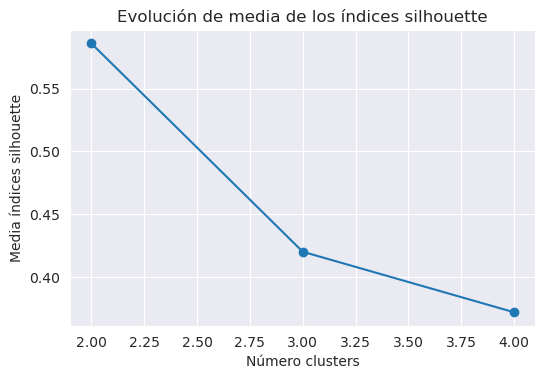

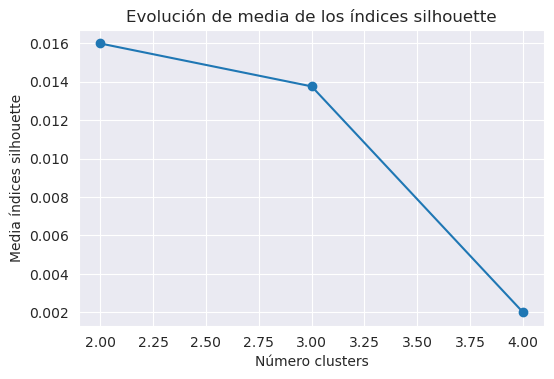

In [ ]:
#Ejemplo de proceso seleccionando un número de cluster
#Paso 1 - Uso de Silueta para la elección de número de atributos, tipo de enlace y distancia
plotSiluette(df_reviews_ejemplo, 'complete', 'euclidean',1)
plotSiluette(df_reviews_ejemplo, 'average', 'minkowski',5)

In [ ]:
#Paso 2: teniendo en cuenta las gráficas, se eligen los parámetros que mejores resultados den
matrizEjemplo3Nodos = hierarchicalClustering(distance_matrix=createDistanceMatrix(instances=df_reviews_ejemplo,numAtributes=1,distanceType='euclidean'),linkType = 'complete',numClusters=2)

              0             1             2             3             4
0  10000.000000      0.623545      0.015128      1.181459      0.210684
1      0.623545  10000.000000      0.638674      0.557914      0.412862
2      0.015128      0.638674  10000.000000      1.196588      0.225812
3      1.181459      0.557914      1.196588  10000.000000      0.970775
4      0.210684      0.412862      0.225812      0.970775  10000.000000
Uso de la memoria en MB:
830.73046875 MB
-----------------------------
iteración número: 1
Clusters aglomerados:
Cluster 1: 0
Cluster 2: 2
              0-2             1             3             4
0-2  10000.000000      0.638674      1.196588      0.225812
1        0.638674  10000.000000      0.557914      0.412862
3        1.196588      0.557914  10000.000000      0.970775
4        0.225812      0.412862      0.970775  10000.000000
-----------------------------
Uso de la memoria en MB:
830.73046875 MB
-----------------------------
iteración número: 2
Clusters

Coordenadas de centroides:
[[ 3.83381664e-01  1.22163616e-16]
 [-3.83381664e-01 -1.22163616e-16]]


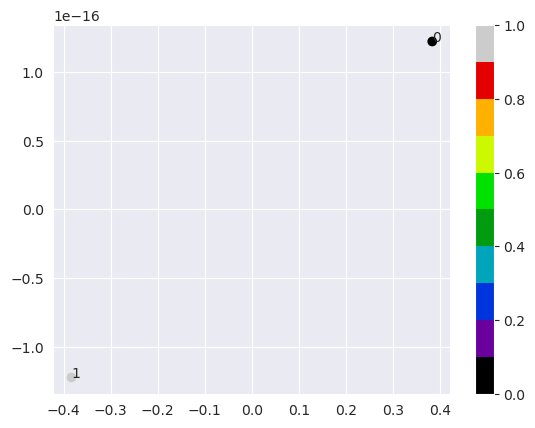

In [ ]:
#Paso 3: Obtener y representar centroides
centroidesEjemplo = calculateCentroids(matrizEjemplo3Nodos, df_reviews_ejemplo)
visualizeCentroids(centroidesEjemplo)